# Useful Image Plotting Functions

## 1. Basics



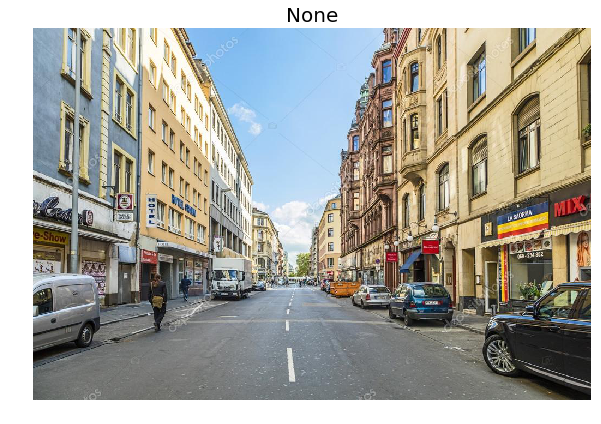

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import matplotlib.image as mpimg
%matplotlib inline

def draw_image(img_file, title=None, figure_size=10, save=False, save_dir=None):
    
    image = mpimg.imread(img_file)
    
    plt.figure(figsize=(figure_size,figure_size))
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.imshow(image.astype(np.uint8))
    
    if save:
        plt.savefig(save_dir)
    
    plt.show()
    
draw_image('data/test2.jpg')

## 2. Multiple images

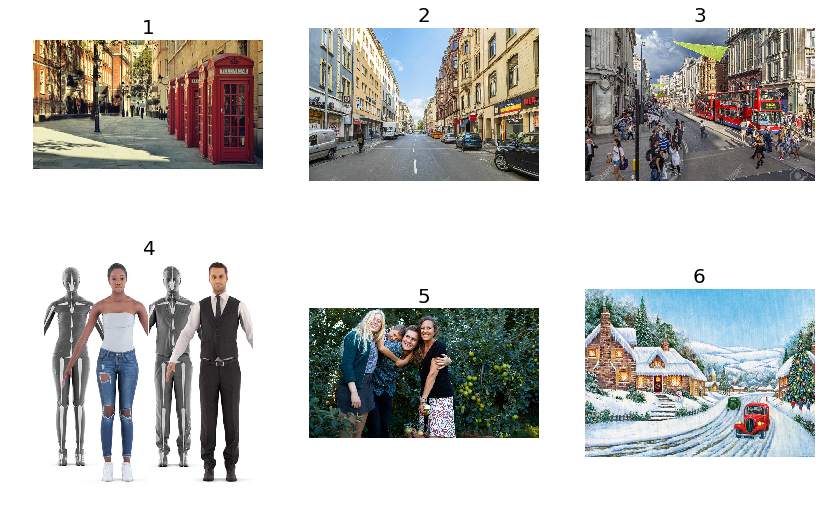

In [22]:
def draw_images(images, titles=None, cols=3, cmap=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    interpolation: Optional. Image interpolation to use for display.
    """
    
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    image_data = []
    for item in images:
        image_data.append(mpimg.imread(item))
    # image_data = np.array(image_data)
    
    for image, title in zip(image_data, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=20)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   interpolation=interpolation)
        i += 1
    plt.show()data/

images = ['data/test1.jpg', 'data/test2.jpg', 'data/test3.jpg', 'data/test4.jpg', 'data/test5.jpg', 'data/test6.jpg']
titles = ['1', '2', '3', '4', '5', '6']
draw_images(images, titles)

## Bounding box and mask (Specific for objection tasks)

In [ ]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [ ]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [ ]:
def draw_boxes(image, boxes=None, 
               masks=None, captions=None, visibilities=None, mask_visibility=0.5, 
               title="", ax=None, colors=None):
    """Draw bounding boxes and segmentation masks with different
    customizations.
    boxes: [N, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [N, height, width]  Bool, representing mask
    captions: List of N titles to display on each box
    visibilities: (optional) Value of 0, 1, or 2. Determine how
        prominent each bounding box should be. 
        0: Gray scale, dotted line 
        1: Colored, dotted line
        2: Colored, solid line
    mask_visibilities: Int, mask visibility. 
    title: An optional title to show over the image
    ax: (optional) Matplotlib axis to draw on.
    colors: [N] color of each box
    """
    # Number of boxes
    assert boxes is not None 
    N = boxes.shape[0]

    # Matplotlib Axis
    if not ax:
        _, ax = plt.subplots(1, figsize=(12, 12))

    # Generate random colors
    if colors == None:
        colors = random_colors(N)

    # Show area outside image boundaries.
    margin = image.shape[0] // 10
    ax.set_ylim(image.shape[0] + margin, -margin)
    ax.set_xlim(-margin, image.shape[1] + margin)
    ax.axis('off')

    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        # Box visibility
        visibility = visibilities if visibilities is not None else 1
        if visibility == 0:
            color = "gray"
            style = "dotted"
            alpha = 0.5
        elif visibility == 1:
            color = colors[i]
            style = "dotted"
            alpha = 1
        elif visibility == 2:
            color = colors[i]
            style = "solid"
            alpha = 1

        # Boxes
        if boxes is not None:
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                  alpha=alpha, linestyle=style,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Captions
        if captions is not None:
            caption = captions[i]
            x = random.randint(x1, (x1 + x2) // 2)
            ax.text(x1, y1, caption, size=11, verticalalignment='top',
                    color='w', backgroundcolor="none",
                    bbox={'facecolor': color, 'alpha': 0.5,
                          'pad': 2, 'edgecolor': 'none'})

        # Masks
        if masks is not None:
            mask = masks[:, :, i]
            masked_image = apply_mask(masked_image, mask, color, mask_visibility)
            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(
                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))


## Display ground truth bounding box/mask and prediction bounding box/mask with confidence score

In [ ]:
def display_bboxes(image, class_names, title="", 
                        gt_box=None, gt_class_id=None,
                        pred_box=None, pred_class_id=None, pred_score=None,
                        ax=None,
                       show_box=True, gt_color='blue', pred_color='green'
                       figsize=(16, 16), save=False, save_dir = None):
    '''
    *_box: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    *_class_id: [num_instances]
    class_names: list of class names of the dataset
    pred_score:  list of confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    '''
    boxes = None
    class_ids = None
    colors = None
    score = None
    if gt_box == None && pred_box == None:
        return
    else if gt_box == None:
        assert pred_box.shape[0] == pred_class_id.shape[0]
        boxes, class_ids = pred_box, pred_class_id
        colors = [pred_color]*boxes.shape[0]
        scores = pred_score
    else if pred_box == None:
        assert gt_box.shape[0] == gt_class_id.shape[0]
        boxes, class_ids = gt_box, gt_class_id
        colors = [gt_color]*boxes.shape[0]
        scores = [None]*boxes.shape[0]
    else: 
        assert gt_box.shape[0] == gt_class_id.shape[0]
        assert pred_box.shape[0] == pred_class_id.shape[0]
        boxes = np.concatenate((gt_box, pred_box), axis=0)
        class_ids = np.concatenate((gt_class_id, pred_class_id), axis=0)
        colors = [gt_color]*gt_box.shape[0] + [pred_color]*pred_box.shape[0]
        scores = [None]*gt_box.shape[0] + pred_score
        
    # Number of instances
    N = boxes.shape[0] + 
    if not N:
        print("\n*** No instances to display *** \n")

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        
        class_id = class_ids[i]
        score = scores[i]
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        caption = captions[i]
        
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

    ax.imshow(masked_image.astype(np.uint8))
    if save:
        plt.savefig(save_dir)
    if auto_show:
        plt.show()

In [ ]:

def display_differences(image, class_names, title="", 
                        gt_box=None, gt_class_id=None, gt_mask=None,
                        pred_box=None, pred_class_id=None, pred_score=None, pred_mask=None,
                        ax=None, mask_visibility=0.5
                        show_mask=True, show_box=True, gt_color='blue', pred_color='green'
                       figsize=(16, 16), save=False, save_dir = None):
    '''
    *_box: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    *_mask: [height, width, num_instances]
    *_class_id: [num_instances]
    class_names: list of class names of the dataset
    pred_score:  list of confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    '''
    boxes = None
    masks = None
    class_ids = None
    colors = None
    score = None
    if gt_box == None && pred_box == None:
        return
    else if gt_box == None:
        assert pred_box.shape[0] == pred_mask.shape[0] == pred_class_id.shape[0]
        boxes, masks, class_ids = pred_box, pred_mask, pred_class_id
        colors = [pred_color]*boxes.shape[0]
        scores = pred_score
    else if pred_box == None:
        assert gt_box.shape[0] == gt_mask.shape[0] == gt_class_id.shape[0]
        boxes, masks, class_ids = gt_box, gt_mask, gt_class_id
        colors = [gt_color]*boxes.shape[0]
        scores = [None]*boxes.shape[0]
    else: 
        assert gt_box.shape[0] == gt_mask.shape[0] == gt_class_id.shape[0]
        assert pred_box.shape[0] == pred_mask.shape[0] == pred_class_id.shape[0]
        boxes = np.concatenate((gt_box, pred_box), axis=0)
        masks = np.concatenate((gt_mask, pred_mask), axis=0)
        class_ids = np.concatenate((gt_class_id, pred_class_id), axis=0)
        colors = [gt_color]*gt_box.shape[0] + [pred_color]*pred_box.shape[0]
        scores = [None]*gt_box.shape[0] + pred_score
        
    # Number of instances
    N = boxes.shape[0] + 
    if not N:
        print("\n*** No instances to display *** \n")

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        
        class_id = class_ids[i]
        score = scores[i]
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        caption = captions[i]
        
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[i, :, :]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if save:
        plt.savefig(save_dir)
    if auto_show:
        plt.show()
    